In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.10.1


In [2]:
def plot_series(time, series, format="-", start = 0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1:]) )
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
    

In [4]:
import csv
time_step = []
temperatures = []
with open("daily-min-temperatures.csv") as csvfile:
    reader=csv.reader(csvfile, delimiter = ',')
    next(reader)
    for row in reader:
        temperatures.append(float(row[1]))
series = np.array(temperatures)
series.mean()

11.177753424657535

In [5]:
print(series.shape[0])
time = np.arange(series.shape[0])
print(series)
print(time)


3650
[20.7 17.9 18.8 ... 13.5 15.7 13. ]
[   0    1    2 ... 3647 3648 3649]


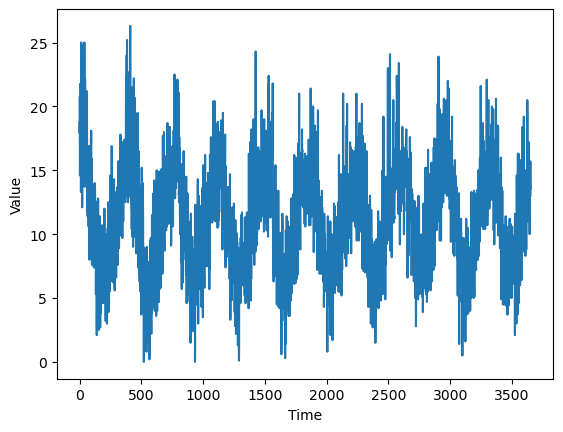

In [6]:
plot_series(time,series)

In [7]:
def model_forecast(model, series, window_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda w:w.batch(window_size))
    dataset = dataset.batch(32).prefetch(1)
    forecast = model.predict(dataset)
    return forecast


In [8]:
tf.keras.backend.clear_session()
split_time = 3000
time_train = time[:split_time]
time_valid = time[split_time:]
x_train = series[:split_time]
x_valid = series[split_time:]

window_size = 5
batch_size = 128
shuffle_buffer_size = 1000

In [9]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 128, kernel_size = 3, strides = 1, padding = "causal", activation = "relu", input_shape = [None, 1]),
    tf.keras.layers.LSTM(32, return_sequences=True),
    
    
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x:x*25)])


In [11]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda  epoch:1e-8*10**(epoch/20))

In [12]:
model.compile(loss = tf.keras.losses.Huber(), optimizer= tf.keras.optimizers.SGD(learning_rate = 1e-6, momentum = 0.9))

In [14]:
history = model.fit(dataset,epochs=300,callbacks=lr_schedule,verbose=1)

Epoch 1/300
24/24 [==============================] - 1s 18ms/step - loss: 4231858176.0000 - lr: 1.0000e-08
Epoch 2/300
24/24 [==============================] - 0s 15ms/step - loss: 336390816.0000 - lr: 1.1220e-08
Epoch 3/300
24/24 [==============================] - 0s 15ms/step - loss: 25663482.0000 - lr: 1.2589e-08
Epoch 4/300
24/24 [==============================] - 0s 15ms/step - loss: 1223813.6250 - lr: 1.4125e-08
Epoch 5/300
24/24 [==============================] - 0s 15ms/step - loss: 1099174.7500 - lr: 1.5849e-08
Epoch 6/300
24/24 [==============================] - 0s 15ms/step - loss: 1256877.6250 - lr: 1.7783e-08
Epoch 7/300
24/24 [==============================] - 1s 18ms/step - loss: 1269456.8750 - lr: 1.9953e-08
Epoch 8/300
24/24 [==============================] - 1s 15ms/step - loss: 1270460.2500 - lr: 2.2387e-08
Epoch 9/300
24/24 [==============================] - 1s 16ms/step - loss: 1270540.0000 - lr: 2.5119e-08
Epoch 10/300
24/24 [==============================] - 0s 1

(1e-08, 0.01, 0.0, 5.0)

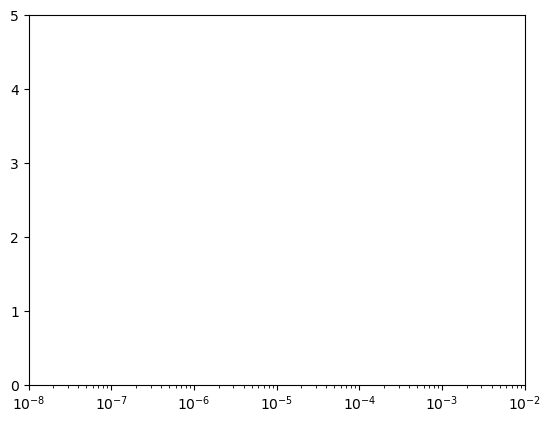

In [16]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-2, 0, 5])

In [17]:
#pick a learning rate between 10-5 ..10-4


In [18]:
model.compile(loss = tf.keras.losses.Huber(), optimizer= tf.keras.optimizers.SGD(learning_rate = 1e-5, momentum = 0.9))

In [19]:
history = model.fit(dataset, epochs=50, verbose = 1)

Epoch 1/50
24/24 [==============================] - 4s 18ms/step - loss: 10811305984.0000
Epoch 2/50
24/24 [==============================] - 0s 15ms/step - loss: 10811305984.0000
Epoch 3/50
24/24 [==============================] - 1s 17ms/step - loss: 10811305984.0000
Epoch 4/50
24/24 [==============================] - 1s 17ms/step - loss: 10811305984.0000
Epoch 5/50
24/24 [==============================] - 1s 18ms/step - loss: 10811305984.0000
Epoch 6/50
24/24 [==============================] - 1s 17ms/step - loss: 10811305984.0000
Epoch 7/50
24/24 [==============================] - 1s 17ms/step - loss: 10811305984.0000
Epoch 8/50
24/24 [==============================] - 1s 16ms/step - loss: 10811305984.0000
Epoch 9/50
24/24 [==============================] - 1s 17ms/step - loss: 10811305984.0000
Epoch 10/50
24/24 [==============================] - 1s 17ms/step - loss: 10811305984.0000
Epoch 11/50
24/24 [==============================] - 1s 17ms/step - loss: 10811305984.0000
Epoch 12

In [20]:
model1_forecast = model_forecast(model, series[..., np.newaxis], window_size)
model1_forecast = model1_forecast[split_time-window_size:-1, -1, 0]

114/114 [==============================] - 1s 5ms/step


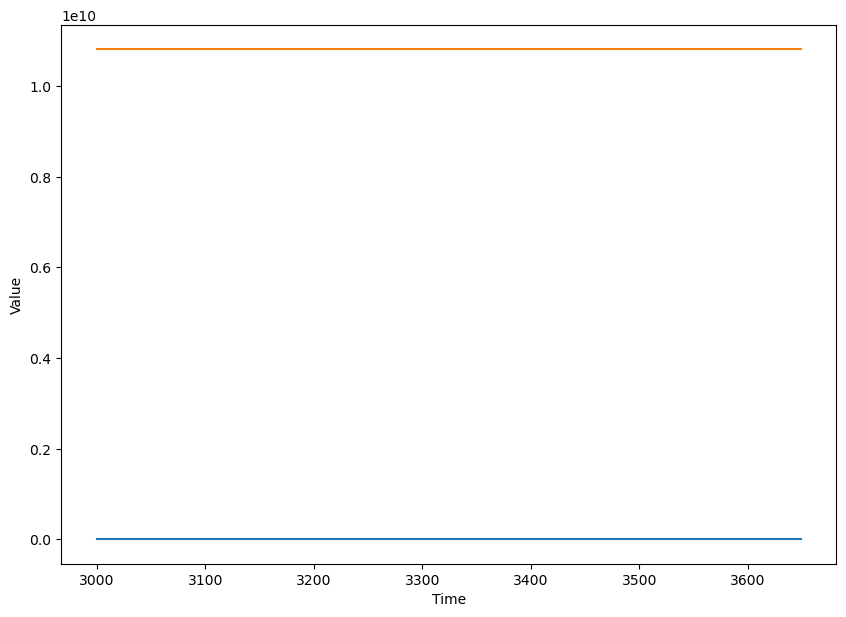

In [21]:
plt.figure(figsize=(10,7))
plot_series(time_valid, x_valid)
plot_series(time_valid, model1_forecast)

In [22]:
tf.keras.metrics.mean_absolute_error(x_valid, model1_forecast).numpy()

10811308000.0